In [ ]:
#pip install tensorflow

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, cohen_kappa_score, confusion_matrix
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Datos

In [91]:
### Trabajar con el dataset original preprocesado para eliminar ruido, nulos y duplicados
df = pd.read_csv('../data/sin_nulos_ventana_2_dias.csv')

# print(df.keys())

# Eliminar las filas con valores faltantes, si las hay
df.dropna(inplace=True)

# Convertir las columnas categóricas a numéricas
encoder = LabelEncoder()
df['RainToday'] = encoder.fit_transform(df['RainToday'])
df['RainTomorrow'] = encoder.fit_transform(df['RainTomorrow'])
df['RainYesterday'] = encoder.fit_transform(df['RainYesterday'])
df['Rain2daysAgo'] = encoder.fit_transform(df['Rain2daysAgo'])

# Seleccionar las características y la columna objetivo
X = df.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir9am', 'WindDir3pm', 'RainTomorrow'], axis=1)
y = df['RainTomorrow']

# Escalar los datos para normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# -----------------------------------------------------------------
numComponents_initial = df.select_dtypes('float64').shape[1]
num_data = df.select_dtypes('float64')

data_transformed_ = (num_data-num_data.min())/(num_data.max()-num_data.min())
X_train, X_test, y_train, y_test = train_test_split(df.select_dtypes('float64'),df['RainTomorrow'], test_size=0.30, random_state=42)
for numComponents in range(numComponents_initial):
    pca = PCA(n_components=numComponents)
    pca.fit(X_train.to_numpy())
    if pca.explained_variance_ratio_.sum()>=0.998:
        break 
projected_train = pca.transform(X_train.to_numpy())
projected_train = pd.DataFrame(projected_train)

projected_test = pca.transform(X_test.to_numpy())
projected_test = pd.DataFrame(projected_test)

X_train=projected_train
X_test=projected_test
# -----------------------------------------------------------------

# Naive Bayes

In [80]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train.values,
    y_train
)
y_pred = gnb.predict(X_test)

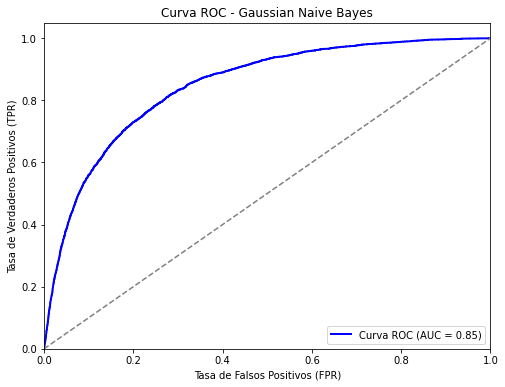

In [81]:

# Obtener las probabilidades de predicción para la clase positiva
y_pred_prob = gnb.predict_proba(X_test)[:, 1]

# Calcular la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr) y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

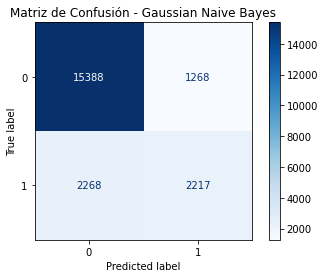

In [82]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=gnb.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Gaussian Naive Bayes')
plt.show()

In [85]:
print('Reporte de clasificación')
print(classification_report(y_test, y_pred))

print('Model accuracy: %0.3f'%accuracy_score(y_test, y_pred))
print('F1 score: %0.3f'%f1_score(y_test, y_pred))
print('Kappa score: %0.3f'%cohen_kappa_score(y_test, y_pred))

Reporte de clasificación
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     16656
           1       0.64      0.49      0.56      4485

    accuracy                           0.83     21141
   macro avg       0.75      0.71      0.73     21141
weighted avg       0.82      0.83      0.82     21141

Model accuracy: 0.833
F1 score: 0.556
Kappa score: 0.455


# Árboles - Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

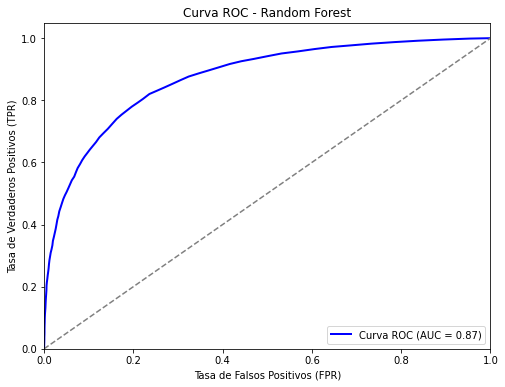

In [88]:
# Obtener las probabilidades de predicción para la clase positiva
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calcular la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr) y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

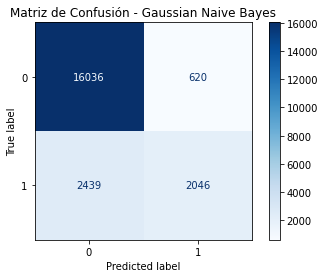

In [89]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=gnb.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Gaussian Naive Bayes')
plt.show()

In [90]:
print('Reporte de clasificación')
print(classification_report(y_test, y_pred))

print('Model accuracy: %0.3f'%accuracy_score(y_test, y_pred))
print('F1 score: %0.3f'%f1_score(y_test, y_pred))
print('Kappa score: %0.3f'%cohen_kappa_score(y_test, y_pred))

Reporte de clasificación
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     16656
           1       0.77      0.46      0.57      4485

    accuracy                           0.86     21141
   macro avg       0.82      0.71      0.74     21141
weighted avg       0.85      0.86      0.84     21141

Model accuracy: 0.855
F1 score: 0.572
Kappa score: 0.492


# Redes Neuronales

In [92]:
# Convertir la variable objetivo a formato categórico (si es necesario)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas para clasificación binaria
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.4450 - accuracy: 0.8250 - val_loss: 0.3450 - val_accuracy: 0.8500
Epoch 2/20
1542/1542 [==============================] - 2s 1ms/step - loss: 0.3583 - accuracy: 0.8447 - val_loss: 0.3436 - val_accuracy: 0.8509
Epoch 3/20
1542/1542 [==============================] - 2s 1ms/step - loss: 0.3514 - accuracy: 0.8480 - val_loss: 0.3360 - val_accuracy: 0.8542
Epoch 4/20
1542/1542 [==============================] - 2s 1ms/step - loss: 0.3489 - accuracy: 0.8476 - val_loss: 0.3356 - val_accuracy: 0.8557
Epoch 5/20
1542/1542 [==============================] - 2s 1ms/step - loss: 0.3472 - accuracy: 0.8486 - val_loss: 0.3343 - val_accuracy: 0.8557
Epoch 6/20
1542/1542 [==============================] - 2s 1ms/step - loss: 0.3460 - accuracy: 0.8509 - val_loss: 0.3330 - val_accuracy: 0.8561
Epoch 7/20
1542/1542 [==============================] - 2s 1ms/step - loss: 0.3432 - accuracy: 0.8509 - val_loss: 0.3377 - val_accuracy:

In [93]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred[:, 1]]  # Convertir las predicciones a clases binarias


661/661 [==============================] - 1s 748us/step


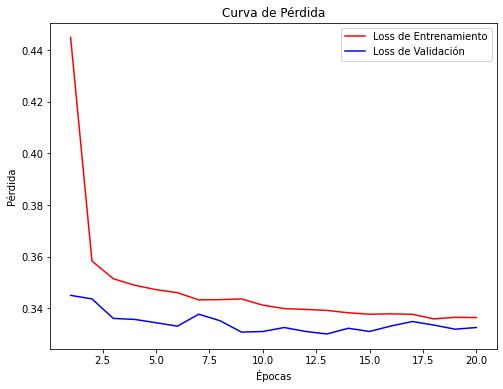

In [94]:
# Obtener la pérdida en el conjunto de entrenamiento y prueba
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la curva de pérdida
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'r', label='Loss de Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss de Validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

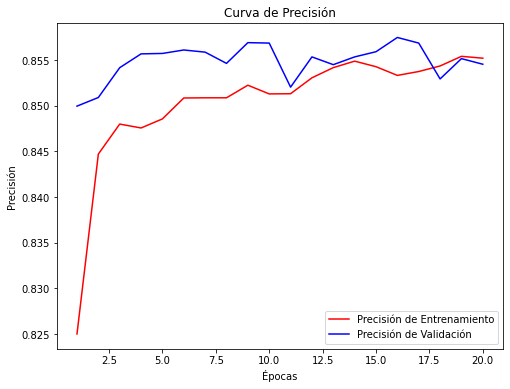

In [95]:
# Obtener la precisión en el conjunto de entrenamiento y prueba
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear un gráfico de la curva de precisión
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'r', label='Precisión de Entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de Validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

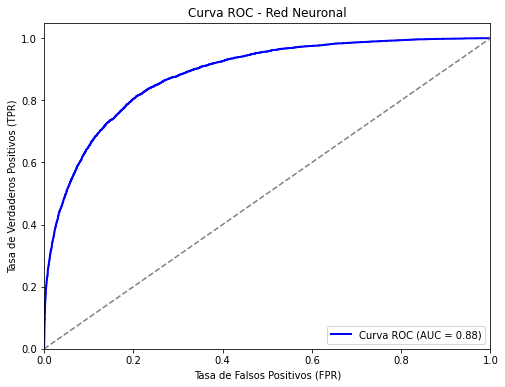

In [96]:
# Obtener las probabilidades de predicción para la clase positiva
y_pred_probs = y_pred[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Red Neuronal')
plt.legend(loc="lower right")
plt.show()

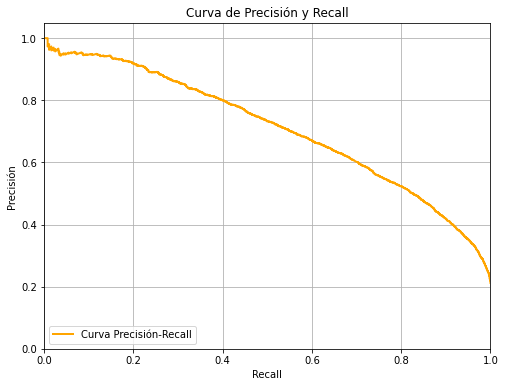

In [97]:
from sklearn.metrics import precision_recall_curve

# Calcular la precisión y el recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Graficar la curva de precisión y recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', lw=2, label='Curva Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión y Recall')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

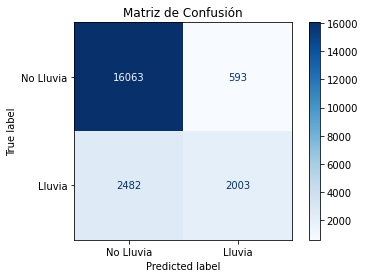

In [98]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Lluvia', 'Lluvia'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

In [99]:
# Obtener el reporte de clasificación por clase
class_report = classification_report(y_test, y_pred_classes)
print("\nReporte de Clasificación por Clase:")
print(class_report)

print('Model accuracy: %0.3f'%accuracy_score(y_test, y_pred_classes))
print('F1 score: %0.3f'%f1_score(y_test, y_pred_classes))
print('Kappa score: %0.3f'%cohen_kappa_score(y_test, y_pred_classes))


Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     16656
           1       0.77      0.45      0.57      4485

    accuracy                           0.85     21141
   macro avg       0.82      0.71      0.74     21141
weighted avg       0.85      0.85      0.84     21141

Model accuracy: 0.855
F1 score: 0.566
Kappa score: 0.486
